In [29]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random, pathlib, sys
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from torchvision import transforms
from omegaconf import OmegaConf as oc
def normalize(data):return (data-np.min(data)) / (np.max(data)-np.min(data))

%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore")

sys.path.insert(0, '/net/scratch/tianh/explain_teach')
import utils.utils as utils
import evals.embed_evals as evals
import utils.plot_data as plot
import utils.gen_triplets as gen

DATASET_SIZE = 2000

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## new features

In [88]:
X = np.load("../datasets/wv_4blobs/4blobs.npz")["X"]
y = np.load("../datasets/wv_4blobs/4blobs.npz")["y"]

In [89]:
new_idx = np.arange(2000)
np.random.shuffle(new_idx)
X = X[new_idx]
y = y[new_idx]

In [91]:
distractors = pickle.load(open("distractors_linear.pkl","rb"))
X = np.hstack([X[:,:2],distractors])

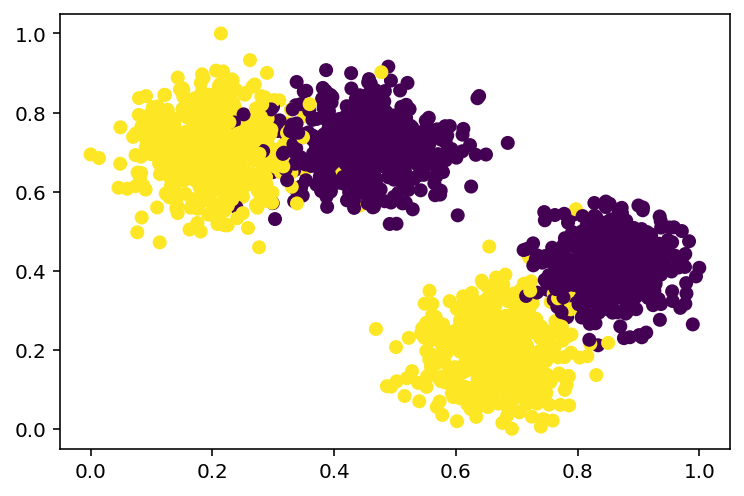

In [93]:
plt.scatter(X[:,0],X[:,1], c=y)

In [94]:
np.savez("/net/scratch/tianh/explain_teach/data/datasets/wv_4blobs/4blobs.npz", X=X, y=y)

## informative features

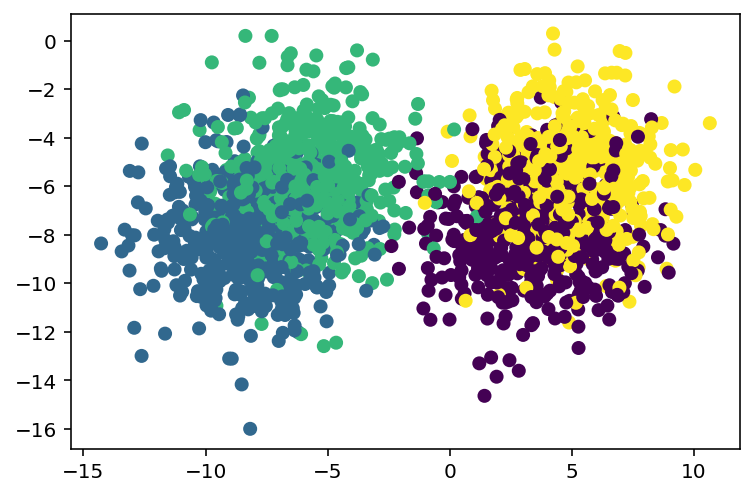

In [101]:
X,y = datasets.make_blobs(DATASET_SIZE, centers=4,cluster_std=2)
plt.scatter(X[:,0],X[:,1],c=y)

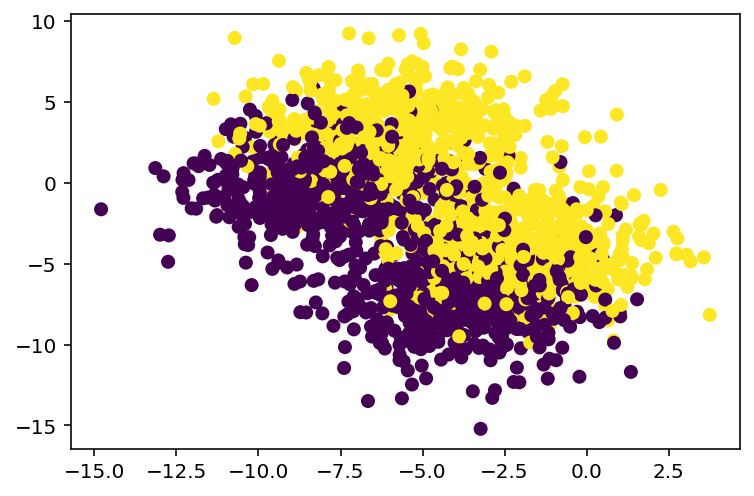

In [66]:
y_ = [0 if i in [0,3] else 1 for i in y]
plt.scatter(X[:,0],X[:,1],c=y_)


## borderless plot

In [11]:
features = ["head size","body size"]

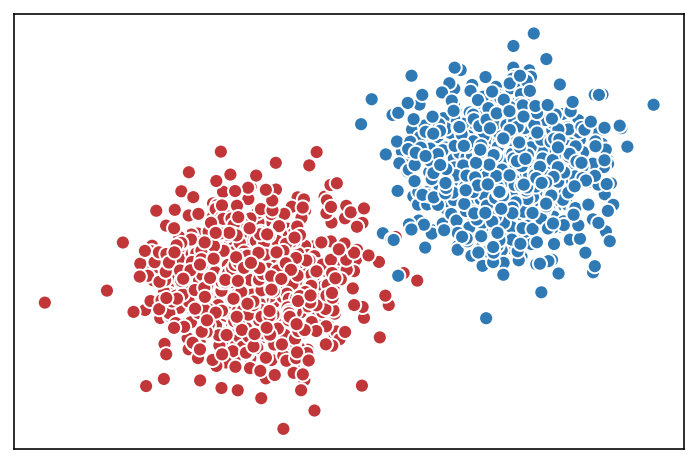

In [12]:
plt.scatter(df[features[0]],df[features[1]], c=df["label"], s=50,
        cmap="RdBu", vmin=-.2, vmax=1.2,
        edgecolor="white", linewidth=1)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

## pseudo label

In [13]:
data = "wv_squarelin"

In [28]:
def plot_boundary(X, y, w, b):
    plt.scatter(X[:,0],X[:,1], s=50,c=y,
            cmap="RdBu", vmin=-.2, vmax=1.2,
            edgecolor="white", linewidth=1)

    xd = np.array([-5,5])
    yd = w*xd + b
    plt.plot(xd, yd, 'k', lw=3, ls='--')

    plt.xlim(min(X[:,0]),max(X[:,0]))
    plt.ylim(min(X[:,1]),max(X[:,1]))
    plt.show()

def gen_plabel(x, y, w, b):
    y_prime = w * x + b
    if y > y_prime: return 1
    else: return 0

In [34]:
df = pd.read_csv("datasets/wv_3d_square/df.csv")
features = ["head size","body size"]

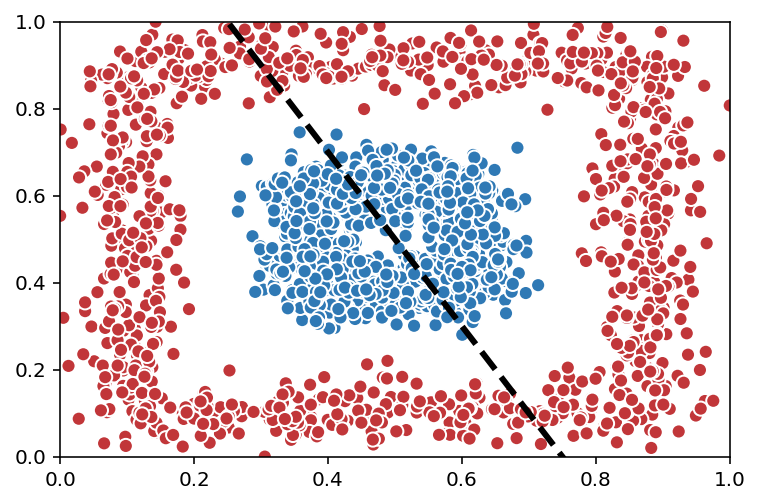

In [35]:
X = df[features].to_numpy()
y = df["label"]
w = -2
b = 1.5
plot_boundary(X, y, w, b)

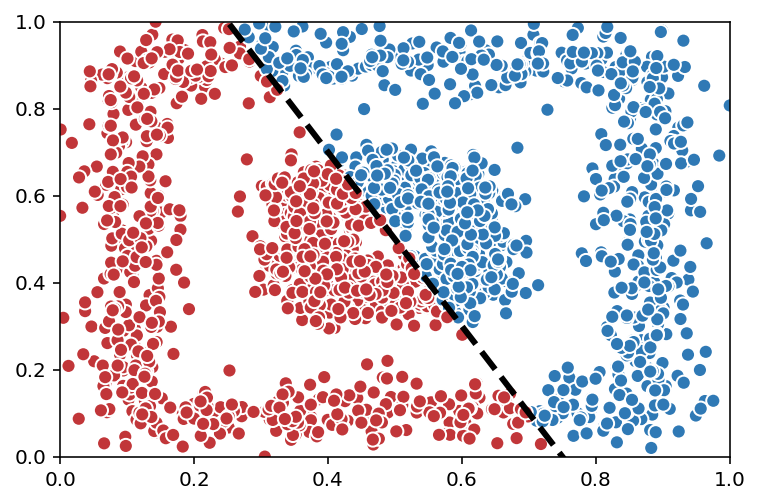

In [36]:
df['label'] = df.apply(lambda row : gen_plabel(row[features[0]], row[features[1]], w, b), axis = 1)
y = df["label"]
w = -2
b = 1.5
plot_boundary(X, y, w, b)

In [39]:
data_dir = f"datasets/{data}"
pathlib.Path(data_dir).mkdir(parents=True, exist_ok=True)
df.to_csv(os.path.join(data_dir,"df.csv"),index=False)